In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression as OLS
import datetime,math
from random import *
from copy import *
seed(123)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
##############################################################
##############################################################

In [4]:
class PolyFit:
    def __init__(self,poly=[2,3,4,5]):
        if 'int' in str(type(poly)): poly=[poly]
        self.poly = poly
        self.models = {}
        
    def fit(self,x_train,y_train,poly=[]):
        if poly: 
            if 'int' in str(type(poly)): poly=[poly]
            self.poly = poly
        x = np.array(x_train)
        y = np.array(y_train)
        if x.shape == (len(x),1): x = x.reshape([len(x),]) 
        if y.shape == (len(y),1): x = x.reshape([len(y),])  
        results = []
        for deg in self.poly:
            params = np.polyfit(x,y,deg)
            self.models[deg] = params    

    def predict(self,x_test): 
        x = np.array(x_test) 
        if x.shape == (len(x),1): x = x.reshape([len(x),])
        results = []
        for deg in self.poly:
            params = self.models[deg] 
            preds = np.polyval(params,x)
            results.append(preds)
        M = np.array(results)
        preds_final = M.mean(0) 
        return preds_final

In [5]:
# Converts Datetime to Decimal Year: 
def dt2dec(dt_obj,base_year=2000,rounded=True):
    try:    
        Year = dt_obj.year
    except: 
        dt_obj = pd.to_datetime(dt_obj)
        Year = dt_obj.year
    year_beg = datetime.datetime(Year,1,1)
    year_end = datetime.datetime(Year+1,1,1)
    tot_sec  = (year_end-year_beg).total_seconds()
    elapsed  = (dt_obj  -year_beg).total_seconds()
    Portion  = elapsed/float(tot_sec) 
    dec_year = Year+Portion-base_year
    if rounded: dec_year = round(dec_year,7) # To Second.
    return dec_year

# Converts Decimal Year to DateTime Object 
def dec2dt(dec_year,base_year=2000):
    Portion = dec_year-int(dec_year)
    Year = int(dec_year)+base_year   
    year_beg = datetime.datetime(Year,1,1)
    year_end = datetime.datetime(Year+1,1,1)
    tot_sec  = (year_end-year_beg).total_seconds()
    elapsed  = int(round(tot_sec*Portion)) 
    delta = datetime.timedelta(seconds=elapsed)
    dt_obj = year_beg+delta
    return dt_obj    

In [6]:
# Fits a line to the data and returns an array of the residuals for y.
# While inputting an array for x and y is preffered, just imputting
# one array will imply that the observations are sequential and
# evenly spaced. 
def Delineate(x_vals=[],y_vals=[]):
    if not y_vals: 
        y_vals = x_vals
        x_vals = range(len(y_vals)) 
    model = PolyFit([1])
    model.fit(x_vals,y_vals)
    preds = model.predict(x_vals)  
    resids = np.array(y_vals)-np.array(preds)
    return resids 

## Using Delineate():  
#L = [1,3,2,4,3,5,4,6,5,7]
#Delineate(L)

In [7]:
def GenSeaEffect(dec_yr,offset=0.0):
    sea = math.cos(2.0*(dec_yr-offset)*math.pi)
    return round(sea,9)

def SeasonEffect(dec_yr,offset=0.0,cycles_per_yr=1.0):
    sea = math.cos((cycles_per_yr*2.0)*(dec_yr-offset)*math.pi)
    return round(sea,9) 

# Converts a distribution to Z-Score Values: 
def ConvertToZ(thing):
    a = np.array(thing)
    return (a-a.mean())/a.std() 

# Subtracts a mean from a distribution:
def DeMean(thing):
    a = np.array(thing)
    return a-a.mean()   

def CalcCorr(x,y):
    return np.corrcoef(x,y)[0][1]

def AddConstant(data_frame):
    data_frame = deepcopy(data_frame) 
    data_frame['const'] = np.ones(len(data_frame))
    cols = [data_frame.columns[-1]]+list(data_frame.columns[:-1])
    return pd.DataFrame(data_frame[cols]) 

In [8]:
# Tests for the optimal cosine parameters for estimating seasonality:
def FindSeasonParams(dates,vals,freqs=[]):   
    if 'float' not in str(type(list(dates)[0])):
        dates = [dt2dec(dt) for dt in pd.to_datetime(dates)]
    #vals = Delineate(dates,vals) 
    vals  = ConvertToZ(vals) 
    if max(dates)>1.0 or min(dates)<0.0:
        dates = [dt-int(dt) for dt in dates]  
    dates = np.array(dates)  
    if not freqs: freqs = [1,2,3,4,5,6,7,8,9,10,11,12,26.1,52.2] 
    best_params = tuple() 
    best_cor = -1.1 
    for freq in freqs: 
        maxoff = 1.0/freq  
        offsets = np.linspace(0.0,maxoff,365)  
        for offset in offsets:
            preds = np.array([SeasonEffect(dt,offset,freq) for dt in dates]) 
            cor = CalcCorr(preds,vals) 
            if cor > best_cor: 
                best_cor = cor
                best_params = (offset,freq) 
    return best_params 

def FindYearlyOffset(dates,vals,freqs=[1]): 
    offset,freq = FindSeasonParams(dates,vals,freqs)  
    return offset 

In [9]:
##############################################################
##############################################################

In [10]:
fn = 'DATA/TestData.csv'
df = pd.read_csv(fn) 
df.index = range(len(df))

In [11]:
DTs = pd.to_datetime(df['DATE'])
df['DEC_YR'] = [dt2dec(dt) for dt in DTs] 

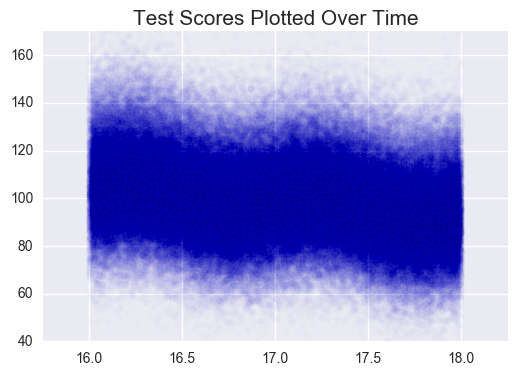

In [12]:
x,y = df['DEC_YR'],df['SCORE']  
plt.clf()
plt.scatter(x,y,alpha=0.01)  
plt.ylim(40,170)
plt.xlim(15.75,18.25)
plt.title('Test Scores Plotted Over Time',size=15)
plt.show()

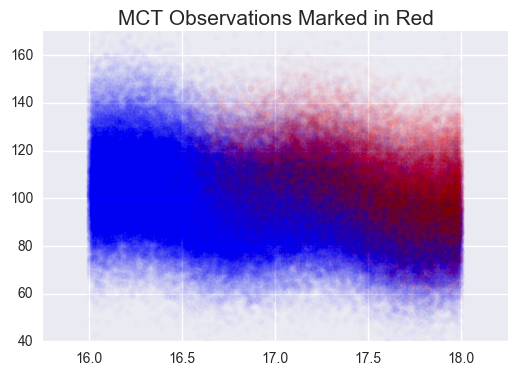

In [13]:
TF = np.array(df['MCT']==1) 
FT = np.logical_not(TF) 
df_mct = df[TF] 
df_non = df[FT]
x1,y1 = df_non['DEC_YR'],df_non['SCORE']
x2,y2 = df_mct['DEC_YR'],df_mct['SCORE']

plt.clf()
plt.scatter(x1,y1,alpha=0.01,color='b')
plt.scatter(x2,y2,alpha=0.01,color='r')
plt.ylim(40,170)
plt.xlim(15.75,18.25)  
plt.title('MCT Observations Marked in Red',size=15)
plt.show() 

In [14]:
y = df['SCORE']
x = df['DEC_YR'] 
model = PolyFit([1])  
model.fit(x,y)
line_x = np.linspace(x.min(),x.max(),100) 
line_y = model.predict(line_x)

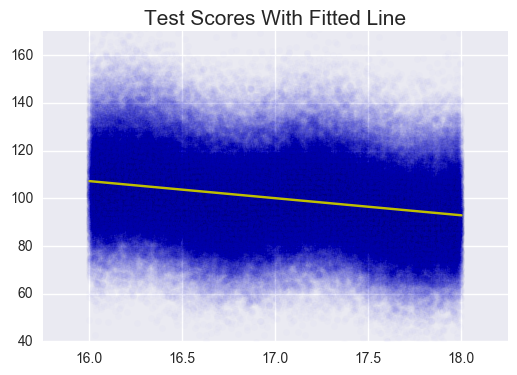

In [15]:
x,y = df['DEC_YR'],df['SCORE']  
plt.clf()
plt.scatter(x,y,alpha=0.01)  
plt.plot(line_x,line_y,c='y') 
plt.ylim(40,170)
plt.xlim(15.75,18.25)
plt.title('Test Scores With Fitted Line',size=15)
plt.show()

In [16]:
YVar  = 'SCORE' 
XVars = ['STU_IQ','STU_ST','STU_BF','DEC_YR'] 

y = df[YVar]
X = df[XVars]
X = AddConstant(X) 

model = sm.OLS(y,X)
result = model.fit() 

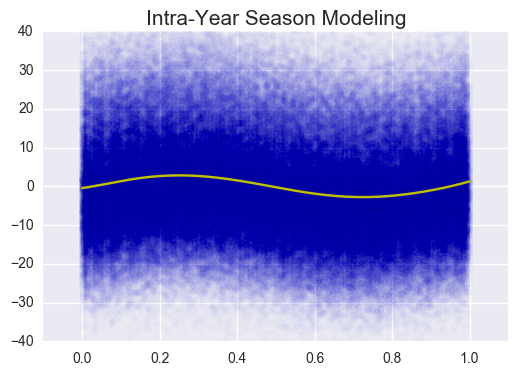

In [17]:
resid = result.resid
dec_d = [a-int(a) for a in df['DEC_YR']] 

model = PolyFit([5,6,7,8,9]) 
model.fit(dec_d,resid) 

line_x = np.linspace(0.0,1.0,365) 
line_y = model.predict(line_x) 

plt.clf()
plt.scatter(dec_d,resid,alpha=0.01)
plt.plot(line_x,line_y,c='y') 
plt.ylim(-40,40)
plt.xlim(-0.1,1.1)
plt.title('Intra-Year Season Modeling',size=15)
plt.show()

In [18]:
##############################################################
##############################################################

In [19]:
print 'Calculating Optimal Cosine Season Fit:'
offset,freq = FindSeasonParams(line_x,line_y)  
print 'Intra-Year Frequency:',freq
print 'Optimal Offset (Yrs):',round(offset,5)

Calculating Optimal Cosine Season Fit:
Intra-Year Frequency: 1
Optimal Offset (Yrs): 0.23626


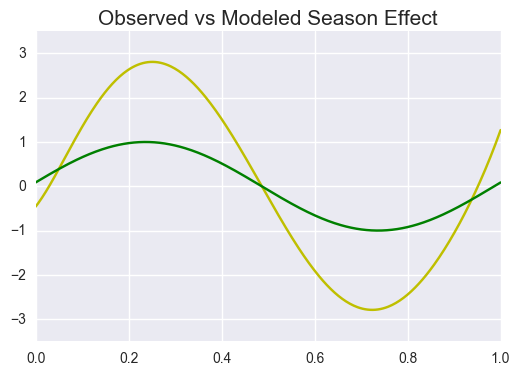

In [20]:
dec_dt  = np.linspace(0.0,1.0,365)  
vals = [SeasonEffect(dec,offset) for dec in dec_dt]  

plt.clf()
plt.plot(line_x,line_y,c='y') 
plt.plot(dec_dt,vals,c='g') 
plt.ylim(-3.5,3.5)
plt.title('Observed vs Modeled Season Effect',size=15)
plt.show() 

In [21]:
CosineSeason = [SeasonEffect(dec,offset) for dec in df['DEC_YR']]  
df['SEASON'] = CosineSeason 

In [22]:
df.head()

,DATE,SCORE,STU_ID,MCT,STU_IQ,STU_ST,STU_BF,ZIP,DEC_YR,SEASON
0,2017-09-10,59.4,GQCPF,0,94.0,3.0,0,70006,17.690411,-0.958785
1,2016-03-29,75.2,NBXEV,0,87.0,13.0,0,71263,16.240437,0.999656
2,2016-11-03,110.4,EARNY,0,116.0,28.0,1,48223,16.838798,-0.799556
3,2016-02-22,110.3,LXPHO,0,104.0,25.0,1,80524,16.142077,0.829940
4,2017-12-22,86.2,KGRBJ,1,118.0,0.0,1,70726,17.972603,-0.085729


In [23]:
##############################################################
##############################################################

In [24]:
FixedModel = "SCORE ~ STU_IQ+STU_ST+STU_BF+MCT+DEC_YR+SEASON"
model = smf.mixedlm(FixedModel, df, groups=df["ZIP"])
result = model.fit() 

In [25]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
============================================================
Model:              MixedLM Dependent Variable: SCORE       
No. Observations:   237546  Method:             REML        
No. Groups:         4726    Scale:              50.4573     
Min. group size:    6       Likelihood:         -814021.9788
Max. group size:    263     Converged:          Yes         
Mean group size:    50.3                                    
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    116.393    0.565  206.050 0.000 115.286 117.500
STU_IQ         0.504    0.001  509.871 0.000   0.502   0.506
STU_ST         0.410    0.001  482.847 0.000   0.408   0.412
STU_BF         6.861    0.031  223.756 0.000   6.801   6.921
MCT           -3.042    0.052  -58.670 0.000  -3.144  -2.940
DEC_YR        -4.856    0.031 -155.933 0.000  -4.917  -4.795
SEASON         3.177    0.023  140.642 0.000   3.133   3.221
Intercept RE 140.111    0.415                               
============================================================

"""

In [27]:
Effect4 = result.params['MCT']
err = Effect4-(-3.14159)
per = 100*err/3.14159 
print 'Predicted MCT Effect on Test Score:',round(Effect4,4),'Points.'
print 'Since the true value is 3.14159, that means that the error'
print 'is',round(err,4), ', making for a error percent of',str(round(per,2))+'%'

Predicted MCT Effect on Test Score: -3.0421 Points.
Since the true value is 3.14159, that means that the error
is 0.0995 , making for a error percent of 3.17%


In [28]:
##############################################################
##############################################################

In [29]:
# [END] 